In [1]:
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from transformers import AutoTokenizer, AutoModelForSequenceClassification


In [2]:
# Load saved DistilBERT model
model_path = "saved_model"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

print(f"Loaded model from {model_path}")


Loaded model from saved_model


In [3]:
# Load dataset
train_df = pd.read_csv("data/Gungor_2018_VictorianAuthorAttribution_data-train.csv", encoding="ISO-8859-1")

# Encode author names
train_df['author_label'] = train_df['author'].astype('category').cat.codes
label_map = dict(enumerate(train_df['author'].astype('category').cat.categories))

# Save label_map if needed
import json
with open("data/label_map.json", "w") as f:
    json.dump(label_map, f)

# Train/validation split (same as during training)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['text'].tolist(),
    train_df['author_label'].tolist(),
    test_size=0.1,
    stratify=train_df['author_label'],
    random_state=42
)

print(f"Validation set size: {len(val_texts)} samples")


Validation set size: 5368 samples


In [4]:
batch_size = 8  # Tune if needed

val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
val_dataset = torch.utils.data.TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'])

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)


In [5]:
all_preds = []
all_labels = []
all_confidences = []

with torch.no_grad():
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        input_ids, attention_mask = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        probs = F.softmax(logits, dim=-1)
        confidences, preds = torch.max(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_confidences.extend(confidences.cpu().numpy())
        all_labels.extend(val_labels[batch_idx * batch_size: (batch_idx + 1) * batch_size])


100%|██████████| 671/671 [00:16<00:00, 39.96it/s]


In [6]:
# Accuracy and F1 Score
acc = accuracy_score(all_labels, all_preds)
macro_f1 = f1_score(all_labels, all_preds, average="macro")

print(f"Accuracy: {acc:.4f}")
print(f"Macro F1 Score: {macro_f1:.4f}")


Accuracy: 0.9408
Macro F1 Score: 0.9212


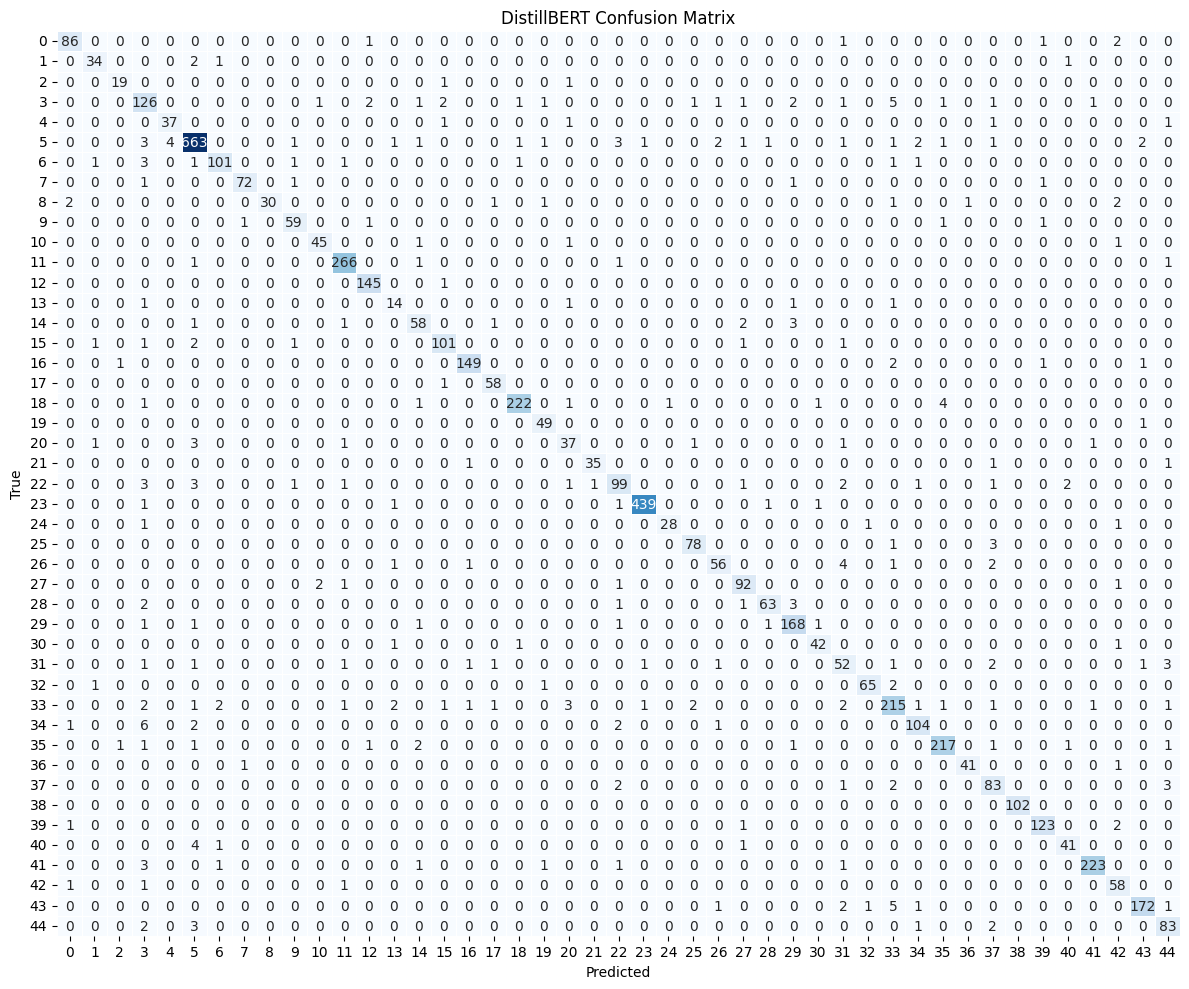

In [7]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap="Blues", annot=True, fmt="d", linewidths=0.5, cbar=False)
plt.title("DistillBERT Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [8]:
# Full classification report
# Find only the labels present in the validation set
present_labels = sorted(set(all_labels))

# Map only those labels
present_target_names = [str(label_map[i]) for i in present_labels]

report_dict = classification_report(
    all_labels,
    all_preds,
    target_names=present_target_names,
    labels=present_labels,
    digits=4,
    output_dict=True  # <-- returns as a Python dict instead of string
)

# Convert to DataFrame and drop aggregate rows
report_df = pd.DataFrame(report_dict).transpose()
report_df = report_df.drop(index=["accuracy", "macro avg", "weighted avg"])

# Sort by F1-score ascending to find worst-performing classes
worst_f1 = report_df.sort_values("f1-score").head()

print("\nWorst performing classes by F1-score:")
print(worst_f1)



Worst performing classes by F1-score:
    precision    recall  f1-score  support
16   0.700000  0.777778  0.736842     18.0
35   0.753623  0.787879  0.770370     66.0
23   0.804348  0.822222  0.813187     45.0
4    0.787500  0.851351  0.818182    148.0
25   0.883929  0.853448  0.868421    116.0


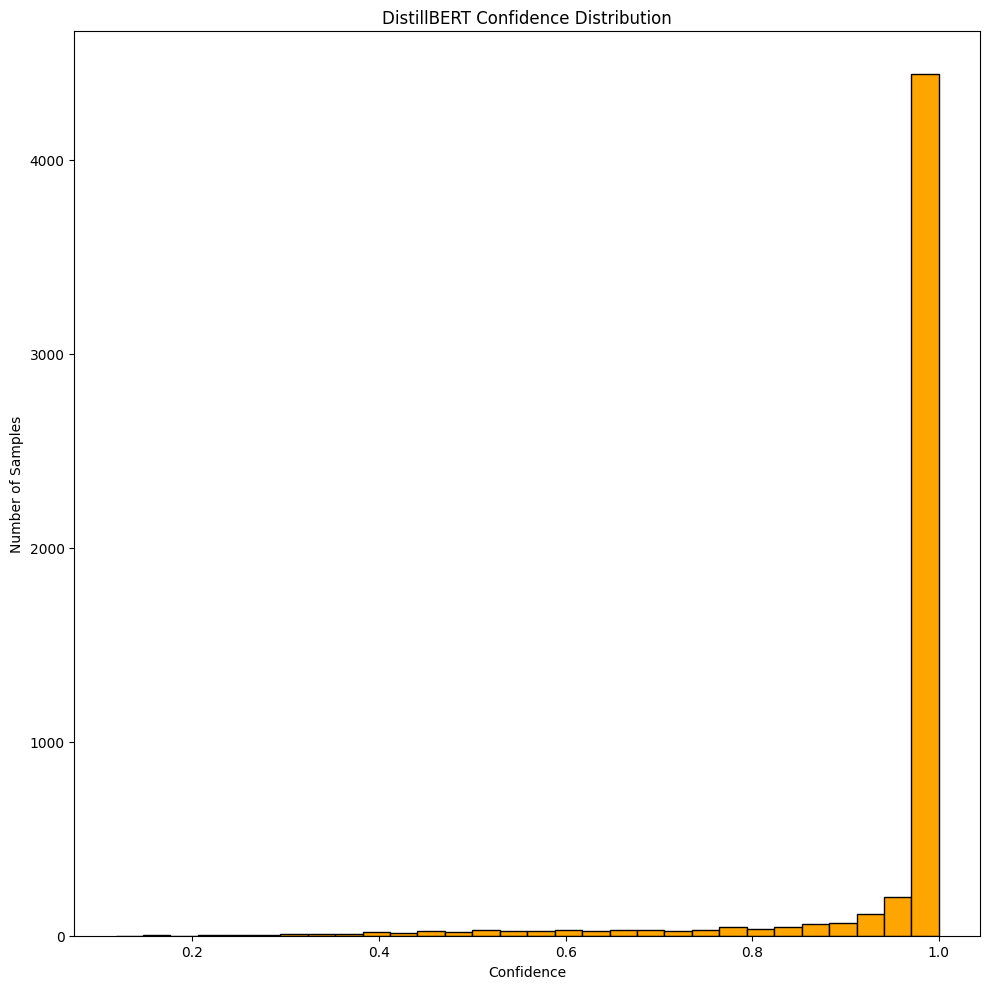

In [9]:
# Confidence histogram
plt.figure(figsize=(10, 10))
plt.hist(all_confidences, bins=30, color='orange', edgecolor='black')
plt.title("DistillBERT Confidence Distribution")
plt.xlabel("Confidence")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.show()


In [10]:
def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Example for DistilBERT or any loaded model
num_params = count_trainable_params(model)
print(f"Number of trainable parameters: {num_params:,}")


Number of trainable parameters: 66,988,077
